In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from time import process_time
from sklearn.model_selection import KFold
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.feature_selection import RFE
from sklearn.metrics import classification_report
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import warnings
warnings.filterwarnings('once')

In [42]:
bucket = 'andrew-data-sagemaker/WeatherClassifier'
data_key = 'WeatherAusReady.csv' 
data_location = 's3://{}/{}'.format(bucket, data_key) 
weather_df = pd.read_csv(data_location)
weather_df.head()

,Unnamed: 0,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,...,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RISK_MM,RainTomorrow,id
0,0,2008-12-01,Albury,13.4,22.9,0.6,11.4,3.126667,W,44.0,...,1007.7,1007.1,8.0,3.0,16.9,21.8,0.0,0.0,No,1
1,1,2008-12-02,Albury,7.4,25.1,0.0,11.4,3.126667,WNW,44.0,...,1010.6,1007.8,3.0,3.0,17.2,24.3,0.0,0.0,No,2
2,2,2008-12-03,Albury,12.9,25.7,0.0,11.4,3.126667,WSW,46.0,...,1007.6,1008.7,3.0,2.0,21.0,23.2,0.0,0.0,No,3
3,3,2008-12-04,Albury,9.2,28.0,0.0,11.4,3.126667,NE,24.0,...,1017.6,1012.8,3.0,3.0,18.1,26.5,0.0,1.0,No,4
4,4,2008-12-05,Albury,17.5,32.3,1.0,11.4,3.126667,W,41.0,...,1010.8,1006.0,7.0,8.0,17.8,29.7,0.0,0.2,No,5


# Feature Engineering Seasons

Convert the date to datetime so we can separate the Year and Months. The apply math formula to convert the month into seasons. 

In [43]:
weather_df['Date'] = pd.to_datetime(weather_df['Date'])

In [44]:
weather_df.Date.dtype

dtype('<M8[ns]')

In [45]:
weather_df['Year'] = weather_df['Date'].dt.year
weather_df['Month'] = weather_df['Date'].dt.month

In [46]:
weather_df['Seasons'] = weather_df['Month'].apply(lambda dt: (dt%12+3)//3)

In [47]:
weather_df.Seasons.value_counts()

2    37397
3    35930
4    34610
1    34256
Name: Seasons, dtype: int64

In [48]:
weather_df.shape

(142193, 29)

In [49]:
raintomorrow_dict = {'Yes': 1, 'No': 0}
weather_df['RainTomorrow'] = weather_df['RainTomorrow'].map(raintomorrow_dict)

# Final Variables

We dummies the seasons because it is a categorical numerical variable where a number isn't better than the other. We also drop unnecessary columns such as Wind Direction and RISK_MM.

In [50]:
weather_df = pd.concat([weather_df, pd.get_dummies(weather_df['Seasons'], prefix="Seasons"), 
                        pd.get_dummies(weather_df['Location'], prefix="Location")], axis = 1)
weather_df.drop(['Seasons', 'Location', 'Unnamed: 0', 'RISK_MM', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 'id', 
                 'Year', 'Month', 'Date'], axis=1, inplace=True)

# Reclusive Feature elimination 

As there is so many varibles and most likely some variables do not contribute to the model well, we will be applying Reclusive Feature Elimination - Logistic Regression. This is applying Logistic Regression modelling but with elimination of features. 

In [51]:
target = 'RainTomorrow'
features = [col for col in weather_df.columns if col != target]
logreg = LogisticRegression()
X = weather_df[features]
y = weather_df[target]
rfe = RFE(logreg, 50)
rfe.fit(X, y.values.ravel())
print(rfe.support_)
print(rfe.ranking_)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/linear_mod

[False False False False  True  True False False False  True  True  True
 False  True False False  True  True False  True False  True  True  True
 False  True  True False  True False  True  True  True  True  True  True
 False  True False  True  True  True  True  True  True  True False  True
  True  True  True  True  True  True  True False  True  True  True  True
  True  True  True  True  True False  True  True  True  True]
[13 20  7 12  1  1 14  6 11  1  1  1 16  1  3 10  1  1 19  1  4  1  1  1
 17  1  1 15  1  9  1  1  1  1  1  1  8  1  5  1  1  1  1  1  1  1 18  1
  1  1  1  1  1  1  1 21  1  1  1  1  1  1  1  1  1  2  1  1  1  1]


In [52]:
rfe_ranks = rfe.ranking_.tolist()
len(rfe_ranks)

70

In [53]:
rfe_table = pd.DataFrame({'features':features, 'ranks':rfe_ranks})
rfe_table = rfe_table.loc[rfe_table['ranks'] == 1]
rfe_features = rfe_table.features.tolist()

In [54]:
len(features)

70

In [55]:
lgr_rfe_weather_df = pd.concat([weather_df[rfe_features], weather_df.RainTomorrow], axis=1)

In [56]:
target = 'RainTomorrow'
features = [col for col in weather_df.columns if col != target]
logreg = LogisticRegression()
X = weather_df[features]
X_std=scaler.fit_transform(X)
y = weather_df[target]
rfe = RFE(logreg, 50)
rfe.fit(X_std, y.values.ravel())
print(rfe.support_)
print(rfe.ranking_)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site

[ True  True  True  True  True  True False  True  True  True  True  True
 False  True  True  True  True  True False  True False  True  True  True
 False  True  True False  True False  True False False  True  True  True
 False  True False  True False  True  True  True  True False False  True
  True  True  True  True  True  True  True False False  True  True False
  True  True False  True  True False  True  True  True False]
[ 1  1  1  1  1  1  8  1  1  1  1  1 15  1  1  1  1  1 12  1 11  1  1  1
 13  1  1 16  1  2  1 20 14  1  1  1  6  1  9  1  4  1  1  1  1  7 17  1
  1  1  1  1  1  1  1 21  3  1  1 18  1  1 10  1  1 19  1  1  1  5]


In [57]:
rfe_ranks = rfe.ranking_.tolist()
len(rfe_ranks)

70

In [58]:
rfe_table = pd.DataFrame({'features':features, 'ranks':rfe_ranks})
rfe_table = rfe_table.loc[rfe_table['ranks'] == 1]
rfe_features = rfe_table.features.tolist()

In [59]:
lgr_rfe_std_weather_df = pd.concat([weather_df[rfe_features], weather_df.RainTomorrow], axis=1)

# Logistic Regression with RFE

In [72]:
X,y = lgr_rfe_weather_df.iloc[:,lgr_rfe_weather_df.columns != 'RainTomorrow'], lgr_rfe_weather_df['RainTomorrow']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

In [73]:
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))
print(classification_report(y_test, y_pred))

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Accuracy of logistic regression classifier on test set: 0.84
              precision    recall  f1-score   support

           0       0.86      0.94      0.90     22098
           1       0.71      0.48      0.57      6341

   micro avg       0.84      0.84      0.84     28439
   macro avg       0.79      0.71      0.74     28439
weighted avg       0.83      0.84      0.83     28439



In [77]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
y_test = y_test.ravel()
print(y_test)
auc = roc_auc_score(y_test, y_pred)
print('AUC: %.3f' % auc)

(array([    0,     1,     7, ..., 28423, 28433, 28434]),)
[1 0 0 ... 0 0 0]
AUC: 0.711


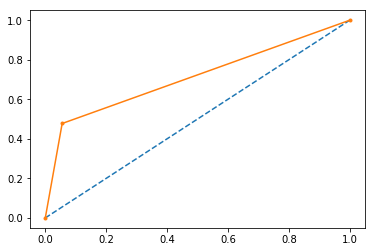

In [81]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr, marker='.')
plt.show()

In [21]:
lgr_rfe_scores = []
lgr_rfe_recalls = []
lgr_rfe_precisions = []
kf = KFold(10, True)
temp_cv_scores = []
cv_lgr_rfe = LogisticRegression()
for train, test in kf.split(X):
    X_train, X_test = X.values[train], X.values[test]
    y_train, y_test = y.values[train], y.values[test]
    cv_lgr_rfe.fit(X_train, y_train)
    y_pred = cv_lgr_rfe.predict(X_test)
    precision, recall, fscore, support = score(y_pred, y_test)
    lgr_rfe_scores.append(fscore)
    lgr_rfe_recalls.append(recall)
    lgr_rfe_precisions.append(precision)
print('Score:', sum(lgr_rfe_scores) / len(lgr_rfe_scores), 'Recall:', sum(lgr_rfe_recalls) / len(lgr_rfe_recalls), 
      'Precision:', sum(lgr_rfe_precisions) / len(lgr_rfe_precisions))

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/linear_mod

Score: [0.90372864 0.5820417 ] Recall: [0.86441783 0.72532565] Precision: [0.94679917 0.48613761]


In [38]:
X,y = lgr_rfe_std_weather_df.iloc[:,lgr_rfe_std_weather_df.columns != 'RainTomorrow'], lgr_rfe_std_weather_df['RainTomorrow']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

In [39]:
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))
print(classification_report(y_test, y_pred))

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Accuracy of logistic regression classifier on test set: 0.84
              precision    recall  f1-score   support

           0       0.87      0.94      0.90     22098
           1       0.72      0.49      0.58      6341

   micro avg       0.84      0.84      0.84     28439
   macro avg       0.79      0.72      0.74     28439
weighted avg       0.83      0.84      0.83     28439



In [40]:
lgr_rfe_scores = []
lgr_rfe_recalls = []
lgr_rfe_precisions = []
kf = KFold(10, True)
temp_cv_scores = []
cv_lgr_rfe = LogisticRegression()
for train, test in kf.split(X):
    X_train, X_test = X.values[train], X.values[test]
    y_train, y_test = y.values[train], y.values[test]
    cv_lgr_rfe.fit(X_train, y_train)
    y_pred = cv_lgr_rfe.predict(X_test)
    precision, recall, fscore, support = score(y_pred, y_test)
    lgr_rfe_scores.append(fscore)
    lgr_rfe_recalls.append(recall)
    lgr_rfe_precisions.append(precision)
print('Score:', sum(lgr_rfe_scores) / len(lgr_rfe_scores), 'Recall:', sum(lgr_rfe_recalls) / len(lgr_rfe_recalls), 
      'Precision:', sum(lgr_rfe_precisions) / len(lgr_rfe_precisions))

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/linear_mod

Score: [0.90437033 0.58606992] Recall: [0.86549348 0.72771824] Precision: [0.94691437 0.49070303]


# Logistic Regression without RFE

In [23]:
X,y = weather_df.iloc[:,weather_df.columns != 'RainTomorrow'], weather_df['RainTomorrow']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

In [24]:
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))
print(classification_report(y_test, y_pred))

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Accuracy of logistic regression classifier on test set: 0.84
              precision    recall  f1-score   support

           0       0.87      0.94      0.90     22098
           1       0.72      0.50      0.59      6341

   micro avg       0.84      0.84      0.84     28439
   macro avg       0.79      0.72      0.75     28439
weighted avg       0.83      0.84      0.83     28439



In [25]:
lgr_scores = []
lgr_recalls = []
lgr_precisions = []
kf = KFold(10, True)
temp_cv_scores = []
cv_lgr = LogisticRegression()
for train, test in kf.split(X):
    X_train, X_test = X.values[train], X.values[test]
    y_train, y_test = y.values[train], y.values[test]
    cv_lgr.fit(X_train, y_train)
    y_pred = cv_lgr.predict(X_test)
    precision, recall, fscore, support = score(y_pred, y_test)
    lgr_scores.append(fscore)
    lgr_recalls.append(recall)
    lgr_precisions.append(precision)
print('Score:', sum(lgr_scores) / len(lgr_scores), 'Recall:', sum(lgr_recalls) / len(lgr_recalls), 
      'Precision:', sum(lgr_precisions) / len(lgr_precisions))

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/linear_mod

Score: [0.9049265 0.5890999] Recall: [0.86625355 0.73014309] Precision: [0.94722756 0.49385369]


In [26]:
scaler=StandardScaler()
X_train_std=scaler.fit_transform(X_train)
X_test_std=scaler.transform(X_test)

In [27]:
logreg.fit(X_train_std, y_train)
y_pred = logreg.predict(X_test_std)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test_std, y_test)))
print(classification_report(y_test, y_pred))

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Accuracy of logistic regression classifier on test set: 0.85
              precision    recall  f1-score   support

           0       0.87      0.95      0.91     11015
           1       0.73      0.52      0.61      3204

   micro avg       0.85      0.85      0.85     14219
   macro avg       0.80      0.73      0.76     14219
weighted avg       0.84      0.85      0.84     14219



In [28]:
lgr_scores = []
lgr_recalls = []
lgr_precisions = []
kf = KFold(10, True)
temp_cv_scores = []
cv_lgr = LogisticRegression()
for train, test in kf.split(X):
    X_train_std, X_test_std = X.values[train], X.values[test]
    y_train, y_test = y.values[train], y.values[test]
    cv_lgr.fit(X_train_std, y_train)
    y_pred = cv_lgr.predict(X_test_std)
    precision, recall, fscore, support = score(y_pred, y_test)
    lgr_scores.append(fscore)
    lgr_recalls.append(recall)
    lgr_precisions.append(precision)
print('Score:', sum(lgr_scores) / len(lgr_scores), 'Recall:', sum(lgr_recalls) / len(lgr_recalls), 
      'Precision:', sum(lgr_precisions) / len(lgr_precisions))

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/linear_mod

Score: [0.90501135 0.58980941] Recall: [0.86644546 0.73018806] Precision: [0.94718081 0.49476898]


# RFE - XGboost

In [26]:
target = 'RainTomorrow'
features = [col for col in weather_df.columns if col != target]
xgboost = XGBClassifier()
X = weather_df[features]
y = weather_df[target]
rfe = RFE(xgboost, 50)
rfe.fit(X, y.values.ravel())
print(rfe.support_)
print(rfe.ranking_)

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True False  True False  True  True  True  True False
 False  True  True  True  True False  True False  True False False False
 False  True  True  True  True False False False  True False False  True
  True  True  True  True  True  True  True  True  True  True  True False
  True  True False False False False  True  True  True  True]
[ 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 17  1  3  1  1  1  1  5
  7  1  1  1  1  9  1 13  1 19 21 20 18  1  1  1  1 11 14 15  1 16 12  1
  1  1  1  1  1  1  1  1  1  1  1  2  1  1  4  6  8 10  1  1  1  1]


In [27]:
rfe_ranks = rfe.ranking_.tolist()
len(rfe_ranks)

70

In [28]:
rfe_table = pd.DataFrame({'features':features, 'ranks':rfe_ranks})
rfe_table = rfe_table.loc[rfe_table['ranks'] == 1]
rfe_features = rfe_table.features.tolist()

In [29]:
xgb_rfe_weather_df = pd.concat([weather_df[rfe_features], weather_df.RainTomorrow], axis=1)

In [30]:
X,y = xgb_rfe_weather_df.iloc[:,xgb_rfe_weather_df.columns != 'RainTomorrow'], xgb_rfe_weather_df['RainTomorrow']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

In [31]:
xgboost_model = XGBClassifier(learning_rate=0.1, n_estimators=1000, max_depth=6, subsample = 0.7, objective= 'binary:logistic')
xgboost_model.fit(X_train, y_train)
xgboost_predictions = xgboost_model.predict(X_test)
print(classification_report(y_test, xgboost_predictions))

              precision    recall  f1-score   support

           0       0.88      0.94      0.91     22098
           1       0.74      0.57      0.64      6341

   micro avg       0.86      0.86      0.86     28439
   macro avg       0.81      0.76      0.78     28439
weighted avg       0.85      0.86      0.85     28439



In [32]:
xgb_rfe_scores = []
xgb_rfe_recalls = []
xgb_rfe_precisions = []
kf = KFold(10, True)
temp_cv_scores = []
cv_xgb_rfe = LogisticRegression()
for train, test in kf.split(X):
    X_train, X_test = X.values[train], X.values[test]
    y_train, y_test = y.values[train], y.values[test]
    cv_xgb_rfe.fit(X_train, y_train)
    y_pred = cv_xgb_rfe.predict(X_test)
    precision, recall, fscore, support = score(y_pred, y_test)
    xgb_rfe_scores.append(fscore)
    xgb_rfe_recalls.append(recall)
    xgb_rfe_precisions.append(precision)
print('Score:', sum(xgb_rfe_scores) / len(xgb_rfe_scores), 'Recall:', sum(xgb_rfe_recalls) / len(xgb_rfe_recalls), 
      'Precision:', sum(xgb_rfe_precisions) / len(xgb_rfe_precisions))

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/linear_mod

Score: [0.90400911 0.58166218] Recall: [0.86415873 0.72811297] Precision: [0.94772694 0.48440166]


# XGBoost 

In [33]:
X,y = weather_df.iloc[:,weather_df.columns != 'RainTomorrow'], weather_df['RainTomorrow']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

In [34]:
xgboost_model = XGBClassifier(learning_rate=0.1, n_estimators=1000, max_depth=6, subsample = 0.7, objective= 'binary:logistic')
xgboost_model.fit(X_train, y_train)
xgboost_predictions = xgboost_model.predict(X_test)
print(classification_report(y_test, xgboost_predictions))

              precision    recall  f1-score   support

           0       0.89      0.94      0.91     22098
           1       0.75      0.57      0.65      6341

   micro avg       0.86      0.86      0.86     28439
   macro avg       0.82      0.76      0.78     28439
weighted avg       0.85      0.86      0.85     28439



In [35]:
xgb_scores = []
xgb_recalls = []
xgb_precisions = []
kf = KFold(10, True)
temp_cv_scores = []
cv_xgb = LogisticRegression()
for train, test in kf.split(X):
    X_train, X_test = X.values[train], X.values[test]
    y_train, y_test = y.values[train], y.values[test]
    cv_xgb.fit(X_train, y_train)
    y_pred = cv_xgb.predict(X_test)
    precision, recall, fscore, support = score(y_pred, y_test)
    xgb_scores.append(fscore)
    xgb_recalls.append(recall)
    xgb_precisions.append(precision)
print('Score:', sum(xgb_scores) / len(xgb_scores), 'Recall:', sum(xgb_recalls) / len(xgb_recalls), 
      'Precision:', sum(xgb_precisions) / len(xgb_precisions))

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/linear_mod

Score: [0.90507168 0.59089914] Recall: [0.86681518 0.72971945] Precision: [0.94686442 0.49647977]


In [36]:
y_pred

array([0, 0, 0, ..., 0, 0, 0])